In [1]:
import numpy as np
from astropy import table
#from reproject import reproject_exact ;not reprojecting in here
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
import sewpy
import iterate_convolution as ic
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
import astropy.table
#from astropy.table import join_distance

In [2]:
#original files to work with
file1='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f606w_drc_sci.fits'
filered='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits'
filereprojd='/home/k689j329/HSTdata/j2106_blue2red_exact.fits'
hrp=fits.open(filered)
hop=fits.open(file1)
hpnew=fits.open(filereprojd)

In [3]:
#show how good the reprojection is by looking at deltax and deltay plots
tableold=ic.makecat(file1)
tablereproj=ic.makecat(filereprojd)

mags1=(-1.0)*np.log10(tableold['FLUX_APER'])
tableold['MAG']=mags1
limtableold=ic.calcfwhm(tableold)
mags2=(-1.0)*np.log10(tablereproj['FLUX_APER'])
tablereproj['MAG']=mags2
limtablereproj=ic.calcfwhm(tablereproj)

('filtered data is size:', 88)
('Median FWHM_IMAGE', 2.045, 'Mean FWHM_IMAGE', 2.1024999999999996)
('filtered data is size:', 73)
('Median FWHM_IMAGE', 1.17, 'Mean FWHM_IMAGE', 1.1631506849315068)


In [5]:
# iterative convolution



#do some calculations about the range of convolution kernels to try
hdr1=hrp[0].header
hdr2=hop[0].header
fwhmpixred=1.95 #from earlier measurements
#cd1red=2.7777777777E-05
cd1red=hdr1['CD1_1']
cdarcred=abs(cd1red) * 3600.0
fwhmarcred= fwhmpixred*cdarcred
fwhmpixblue=2.5 #from earlier measurements
#cd1blue=1.388888888E-05
cd1blue=hdr2['CD1_1']
cdarcblue=abs(cd1blue)*3600.0
fwhmarcblue=fwhmpixblue*cdarcblue
#cd reprojected?
hdrnew=hpnew[0].header
cdreproj=hdrnew['CD1_1']
cdarcreproj=abs(cdreproj)*3600.0

print('cdarcblue and cdarcreproj',cdarcblue,cdarcreproj)
#an average in-between value would be calculated like this: fwhm2=((fwhmarcred**2.0)-(fwhmarcblue**2.0))**(1/2)

print('fwhmarcblue,fwhmpixblue:',fwhmarcblue,fwhmpixblue)
print('fwhmarcred,fwhmpixred:',fwhmarcred,fwhmpixred)

#now, what exactly do we want?
#we want an average star's FWHM in the convolved image to be as close as possible to FWHM_red

yarray1=np.linspace(fwhmarcred,fwhmarcblue,10,endpoint=True)
yarray=yarray1/cdarcreproj


#this was for making the new convolution files but that's done now
files=[]
i=0
for item in yarray:
    filename=ic.conv2Dgauss(filereprojd,item,i)
    i+=1
    files.append(filename)
    print(filename)
print('done convolving')

('cdarcblue and cdarcreproj', 0.049999999999996804, 0.0999999999999972)
('fwhmarcblue,fwhmpixblue:', 0.124999999999992, 2.5)
('fwhmarcred,fwhmpixred:', 0.19499999999999454, 1.95)
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan210.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan211.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan212.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan213.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan214.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan215.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan216.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan217.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan218.fits
convolving...
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan219.fits
done convolving


In [8]:
#now need to run SE, make a table, and find out how to work with that table
#convolved j2106_f606w's best stellar sequence is fwhm_image <5 mag -2.2 to -1.0
#add a column containing ~magnitude
#files=['/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan210.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan211.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan212.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan213.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan214.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan215.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan216.fits']
i=len(files)
fwhm_median=[]
i=0
for item in files:
    print(item)
    yval=yarray[i] #in pixels
    table1=ic.makecat(item)
    mags=(-1.0)*np.log10(table1['FLUX_APER'])
    table1['MAG']=mags
    #plt.plot(table1['MAG'],table1['FWHM_IMAGE'],'ro')
    #plt.title('Does the stellar sequence stay appropriate in this pre-determined range?')
    #plt.ylim(0.0,4.5)
    #plt.xlim(-2.2,-1.0)
    #plt.show()
    print('convolved by FWHM',yval,'pixels')
    newlimitedtable=ic.calcfwhm(table1)
    #you can enter plottin=True as an optional argument in calcfwhm
    #that lets you see the stellar sequence that falls in the selection range used for making a new, limited table
    fwhmmed=np.median(newlimitedtable['FWHM_IMAGE'])
    fwhm_median.append(fwhmmed)
    i+=1




/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan210.fits
('convolved by FWHM', 1.95, 'pixels')
('filtered data is size:', 77)
('Median FWHM_IMAGE', 2.37, 'Mean FWHM_IMAGE', 2.422597402597403)
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan211.fits
('convolved by FWHM', 1.8722222222222173, 'pixels')
('filtered data is size:', 77)
('Median FWHM_IMAGE', 2.29, 'Mean FWHM_IMAGE', 2.338051948051948)
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan212.fits
('convolved by FWHM', 1.7944444444444343, 'pixels')
('filtered data is size:', 73)
('Median FWHM_IMAGE', 2.2, 'Mean FWHM_IMAGE', 2.2584931506849313)
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan213.fits
('convolved by FWHM', 1.7166666666666517, 'pixels')
('filtered data is size:', 74)
('Median FWHM_IMAGE', 2.12, 'Mean FWHM_IMAGE', 2.169594594594595)
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan214.fits
('convolved by FWHM', 1.6388888888888689, 'pixels')
('filtered data is size:', 77)
('Median FWHM_IMAGE', 2.04, 'M

In [33]:
#okay the best fit is /home/k689j329/HSTdata/j2106_blue2red_exact_conv_jan215.fits

tablebest=ic.makecat(files[5])
mags=(-1.0)*np.log10(tablebest['FLUX_APER'])
tablebest['MAG']=mags
newlimbest=ic.calcfwhm(tablebest)
evenmorelim=newlimbest
#evenmorelim=newlimbest[np.where(newlimbest['CLASS_STAR'] > 0.75)]
outregions=list()
leny=len(evenmorelim)
print(leny)
j=0
while j < (leny):
    x=evenmorelim[j]['X_IMAGE']
    y=evenmorelim[j]['Y_IMAGE']
    out1='circle('+str(x)+','+str(y)+',10)'
    outregions.append(out1)
    j+=1
    
f=open('/home/k689j329/HSTdata/j2106_blue2red_stars2.reg','a+')
f.writelines("%s\n" % item for item in outregions)
f.close()


('filtered data is size:', 78)
('Median FWHM_IMAGE', 1.95, 'Mean FWHM_IMAGE', 1.955641025641026)
78


In [10]:
#original test of convolution

#y is the stddev needed for the Gaussian 2D kernel
#Let’s try j210604m5845, which has a 0.5” depth of ~27.6 AB mag for both F105W and F606W because of times observed
#f105w: fwhm_image average for the best stars (on the sequence, plus classstar > 0.98) 1.95, and for just the
#ones on the sequence, 1.99, so that’s pretty good. 
#pixels aHA, pixel scale: 2.77777777777777E-05 “/pixel (…. no. I think it’s radians. so that’s 5.72957795131 “/pix 
#and so in arcsec: 11.1726770051 “ FWHM)--greg said something about degrees, though? 
#ah, yes, decimal degrees, so 2.777777e-05 decimal degrees == 0.1 “/pixel, 
#so 1.95 pixel FWHM is 0.195 arcsec FWHM
#f606w; fwhm_image ~2.5 pixels and plate scale in decimal degrees: CD1_1 = -1.3888888888888E-05 decimal degrees 
#== 0.05 “/pixel, giving 0.125 arcsec fwhm WOO, it's bluer and it has a "higher resolution" ie a smaller FWHM
#use them to give the stddev size of a 2Dgaussiankernel, I think. --FWHM = 2sqrt(2ln2) * stddev
#FWHM=2*sqrt(2ln2)*stdev, so stdev=FWHM/2sqrt(2ln2)

#so, I want to convolve it with a kernel that's somewhere between 0.125 and 0.195 arcsec in fwhm.
#rsmall=0.125, rbig=0.195, rconv=0.15
#std-dev of 2D Gaussian kernel should be 0.15/2sqrt(2*ln2) = 0.06369913502
#let's try to do that calculation more generally
hdr1=hrp[0].header
hdr2=hop[0].header
fwhmpixred=1.95
#cd1red=2.7777777777E-05
cd1red=hdr1['CD1_1']
cdarcred=abs(cd1red) * 3600.0
fwhmarcred= fwhmpixred*cdarcred
fwhmpixblue=2.5
#cd1blue=1.388888888E-05
cd1blue=hdr2['CD1_1']
cdarcblue=abs(cd1blue)*3600.0
fwhmarcblue=fwhmpixblue*cdarcblue
#fwhm2=(fwhmarcred^2-fwhmarcblue^2)^(1/2)
#can use fwhm2 instead of fwh below 
print(fwhmarcred, fwhmarcblue, 'fwhmarc')
fwh1=0.15
#okay, this is written in arcsec but I need it in terms of pixels
fwh=fwh1/cdarcblue
y=fwh/(2*np.sqrt(2*np.log(2)))
#y2=fwhm2/(2*np.sqrt(2*np.log(2)))
print('std-dev for J2106',y)


#convolution

kern=Gaussian2DKernel(y)#,x_size=9,y_size=9)
img=hpnew[0].data
astrconv=convolve(img,kern)
hpnew[0].data=astrconv

#output
tmpfile=filereprojd
tmpname=tmpfile.split('/')
tmp2=tmpname[len(tmpname)-1]
filename=tmp2.replace('.fits','')
outfile='/home/k689j329/HSTdata/'+filename+'_conv_dec20.fits'
#hpnew.writeto(outfile)
plt.imshow(kern)
plt.colorbar()
plt.show()


0.19499999999999454 0.124999999999992 fwhmarc
std-dev for J2106 1.27398270043211


OSError: File '/home/k689j329/HSTdata/j2106_blue2red_exact_conv_dec20.fits' already exists.

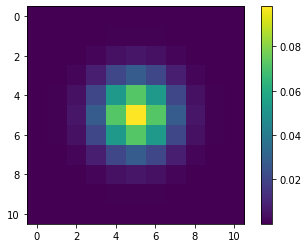

In [10]:
#okay, the output doesn't look any different. let me inspect the Gaussian some more.
#Gaussian2DKernel needs an input of standard deviation 'in x', it says
#perhaps that means in pixels as opposed to in arcsec
plt.imshow(kern)
plt.colorbar()
plt.show()

In [ ]:
#well, that answers that question. no change, cuz basically multiplying by nothing. 
#What does the kernel look like in terms of pixels? well, in F606w, that is 2.5 pix
#but there's no point in multiplying F606W by an approximation of F606W's PSF
#how about translating the fwhm of F105w's PSF into what it would look like given F606W's pixel scale?
#in otherwords, fwhm_f105w(arcsec) / (arcsec/pix) of f606w.
#in that case:
ytest=0.15 / cdarcblue
print(ytest)
kern2=Gaussian2DKernel(ytest)
plt.imshow(kern2,interpolation='None',origin='lower')
plt.colorbar()
plt.show()

In [ ]:
#okay, that sounds more reasonable, so let's try convolving with that
#astrc2=convolve(img,kern2)
#hop[0].data=astrc2
#hop.writeto(outfile)
#that is a little more accurate looking, but I used the FWHM instead of the stdev, so hold on and let's try v3
kern3=Gaussian2DKernel(ytest/2.35)
plt.imshow(kern3,interpolation='None',origin='lower')
plt.colorbar()
plt.show()

below this is reprojection work that eventually led to the program reproj_kmj.py, which is found in the reprojectin folder

In [ ]:
# reprojection
#this was too big to run because of reproject_exact; I had to write a program to run it
#and was only able to execute the program over on redbud
file='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f606w_drc_sci.fits'
filered='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits'
hrp=fits.open(filered)
hop=fits.open(file)
array2,footprint1= reproject_exact(hop,hrp[0].header)

fits.writeto('/home/k689j329/HSTdata/j2106_blue2red_exact.fits', array2, hrp[0].header, overwrite=True)
print('done reprojectin')

#whtfileblue='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f606w_drc_wht.fits'
#whtfilered='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_wht.fits'
#wb=fits.open(whtfileblue)
#wr=fits.open(whtfilered)
#whtarray2,footprintwht=reproject_exact(wb,wr[0].header)
#fits.writeto('/home/k689j329/HSTdata/j2106_blue2red_exact_wht.fits',whtarray2,wr[0].header,overwrite=True)

#okay, this seems to rescale j2106_blue (aka j2106_f606w), but it doesn't make the sizes and shapes match. 
#should it?
#it should register the images so that without using lock or match in ds9, blink demonstrates they are matched. that is true

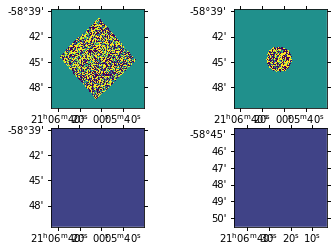

In [7]:
ax1 = plt.subplot(2,2,1, projection=WCS(hop[0].header))
ax1.imshow(hop[0].data, origin='lower', vmin=-5.e-3, vmax=5.e-3)
#okay so the important thing is the relation between the projection and the data used
#hop/hop and hrp/hrp produce the same coordinates; but when you mix them up then there's shifting. 
#that makes sense, that's the point of a projection I suppose
ax2 = plt.subplot(2,2,2, projection=WCS(hrp[0].header))
ax2.imshow(hrp[0].data,origin='lower',vmin=-5.e-3,vmax=5.e-3)

#ax3 = plt.subplot(2,2,3,projection=WCS(hop[0].header))
#ax3.imshow(hrp[0].data,origin='lower',vmin=-5.e-3,vmax=5.e-3)
#ax4 = plt.subplot(2,2,4,projection=WCS(hrp[0].header))
#ax4.imshow(hop[0].data,origin='lower',vmin=-5.e-3,vmax=5.e-3)

ax5= plt.subplot(2,2,3,projection=WCS(hrp[0].header))
ax5.imshow(footprint1,vmin=0,vmax=5)
ax6 = plt.subplot(2,2,4,projection=WCS(hop[0].header))
ax6.imshow(footprint1,vmin=0,vmax=5)